<a href="https://colab.research.google.com/github/yebiny/SkillTreePython-DeepLearning/blob/main/04.Paper-with-code/comment/ch04_06_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch04.06 AutoEncoder

* 날짜:
* 이름:

## 학습내용
    - AutoEncoder를 이해하고 구현한다.
    - Denoising 을 적용해 본다. 
    - 이상치 탐지를 적용해 본다. 

In [1]:
import sys, os
sys.path.append('/content/drive/MyDrive/scripts/')
from lib import *

## AutoEncoder 기본 구현
---

![](https://gaussian37.github.io/assets/img/dl/concept/autoencoder2/autoencoder.png)

### **| 모델 구성**

In [21]:
# 이미지 -> 이미지 norm : x/255 x 값이 0~1 사이 (0 또는 1이 아님!)

# mnist : 28 x 28 = 784
def create_model(input_dims=784):
  # encoder
  x = layers.Input(shape=input_dims, name='x')
  z = layers.Dense(128, activation='relu')(x)
  z = layers.Dense(64, activation='relu')(z)
  z = layers.Dense(16, activation='relu')(z)
  encoder = models.Model(x, z, name='Encoder')

  # decoder
  y = layers.Dense(64, activation='relu')(z)
  y = layers.Dense(128, activation='relu')(y)
  y = layers.Dense(input_dims, activation='sigmoid')(y)
  decoder = models.Model(z, y, name='Decoder')

  # AutoEncoder
  z = encoder(x)
  y = decoder(z)
  model = models.Model(x, y, name='AutoEncoder')
  model.compile(loss= 'mse', 
                optimizer='adam')

  model.summary()

  return encoder, decoder, model

#def create_cnnbase(input_dims):



In [22]:
encoder, decoder, model = create_model()

Model: "AutoEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 784)]             0         
                                                                 
 Encoder (Functional)        (None, 16)                109776    
                                                                 
 Decoder (Functional)        (None, 784)               110544    
                                                                 
Total params: 220,320
Trainable params: 220,320
Non-trainable params: 0
_________________________________________________________________


### **| 학습**

In [19]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# norm
x_train = x_train / 255.0
x_test = x_test / 255.

# flatten
x_train = x_train.reshape( (60000, -1) )
x_test = x_test.reshape( (10000, -1) )

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [45]:
history = model.fit(x_train, x_train, epochs=50, batch_size=128)

Epoch 1/50
469/469 [==============================] - 5s 9ms/step - loss: 0.0508
Epoch 2/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0266
Epoch 3/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0232
Epoch 4/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0216
Epoch 5/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0205
Epoch 6/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0196
Epoch 7/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0186
Epoch 8/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0176
Epoch 9/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0169
Epoch 10/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0163
Epoch 11/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0159
Epoch 12/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0156
Epoch 13/50
469/469 [====

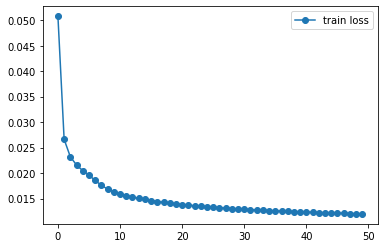

In [46]:
l = history.history['loss']
plt.plot(l, marker='o', label='train loss')
plt.legend()
plt.show()

### **| 결과 확인**

In [47]:
x_recon = model.predict(x_test)
x_test.shape, x_recon.shape

((10000, 784), (10000, 784))

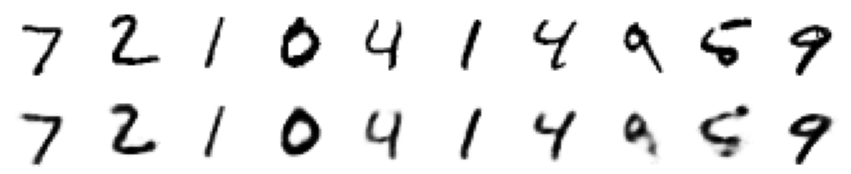

In [48]:
def display_res(org, rec):
  plt.figure(figsize=(15,3))
  for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(org[i].reshape(28,28), cmap='gray_r')
    plt.axis('off')
    plt.subplot(2,10,i+11)
    plt.imshow(rec[i].reshape(28,28), cmap='gray_r')
    plt.axis('off')
  plt.show()

display_res(x_test, x_recon)

In [49]:
z =encoder(x_test[:1000])
z.shape

TensorShape([1000, 16])

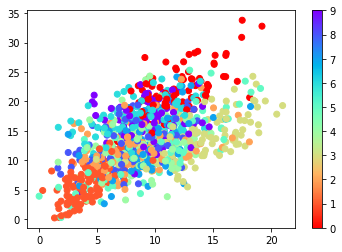

In [50]:
plt.scatter(z[:,1], z[:,2], c=y_test[:1000], cmap='rainbow_r')
plt.colorbar()

## AutoEncoder 활용 - Denoising
---

### **| 데이터 준비**

(60000, 784) (10000, 784)


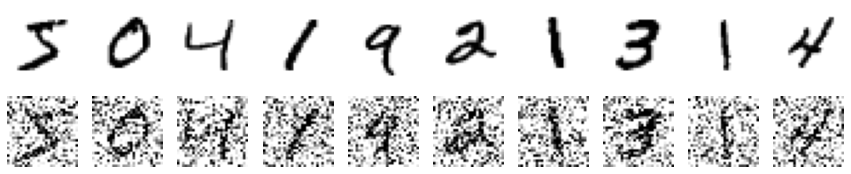

In [60]:
train_noise = np.random.normal(size=x_train.shape)
test_noise = np.random.normal(size=x_test.shape)

factor = 0.6
x_train_noisy = x_train + train_noise * factor
x_test_noisy = x_test + test_noise * factor

# 0~1 범위를 벗어나지 않도록
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

print(train_noise.shape, test_noise.shape)
display_res(x_train, x_train_noisy)

### **| 훈련**

In [ ]:
history = model.fit(x_train_noisy, x_train , epochs=50, batch_size=128)

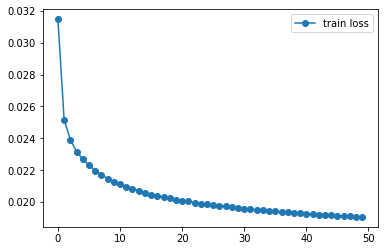

In [63]:
l = history.history['loss']
plt.plot(l, marker='o', label='train loss')
plt.legend()
plt.show()

### **| 결과 확인**

In [65]:
x_recon = model.predict(x_test_noisy)
x_recon.shape, x_test_noisy.shape

((10000, 784), (10000, 784))

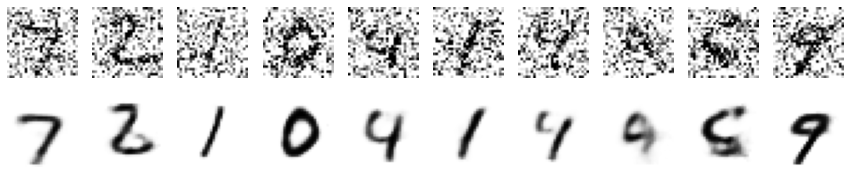

In [66]:
display_res(x_test_noisy, x_recon)

## AutoEncoder 활용 - 이상치 탐지
---

### **| 모델 구성**

### **| 데이터 준비**


### **| 훈련**

### **| 결과 확인**